### Grid Approach to enhance or eliminate bias in the training subsets. 

In [1]:
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader, SubsetRandomSampler, Subset, ConcatDataset
import os
from Truncate import truncate
from BSI_Entropy import BSIE
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Like what we did in the original file, we set up all the classes/functions properly and prepare our datasets

In [2]:
data_dir = './data/cifar10'
training_dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [5]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [6]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [7]:
device = get_default_device()
device

device(type='cpu')

#### We now create a CNN model object from the class above and assign it trained parameters we stored. This CNN model will be our embedding function to help us extract feature space of images. 

In [8]:
modelCNN = to_device(Cifar10CnnModel(), device)

In [9]:
modelCNN.load_state_dict(torch.load('cifar10-cnn.pth')) # load our pretrained model parameters and assign to the new model object

<All keys matched successfully>

In [10]:
from torch.utils.data.dataloader import DataLoader
batch_size=128
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
evaluate(modelCNN, test_loader) # this will make sure it is the same CNN model we trained initially. 

{'val_loss': 0.9372484087944031, 'val_acc': 0.7689453363418579}

#### This following function will help us to attain intermediate features of images before the final classification layer of the CNN model which is our embedding function in this case.

In [11]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()

    return hook

In [12]:
modelCNN.network[18].register_forward_hook(get_features('18'))

#### In the following code, we attain the intermediate feature space for each class in the training set

In [13]:
class_feature_data = {label: [] for label in range(10)}

In [14]:
for image, label in training_dataset:
    if label in class_feature_data:
        output = modelCNN(to_device(image.unsqueeze(0), device))
        class_feature_data[label].append(features['18'])

In [15]:
for label in class_feature_data:
    class_feature_data[label] = torch.cat(class_feature_data[label], dim = 0).T 

##### We then apply SVD to the feature space of each training class to attain singular vector. 

In [16]:
singular_vector = {label: torch.svd(class_feature_data[label])[1] for label in class_feature_data}
print(singular_vector)

{0: tensor([8305.8789, 1585.3182, 1073.5406,  963.0099,  828.8642,  769.5621,
         616.4266,  580.3412,  516.1616,  488.6954,  402.4275,  341.2084,
         275.5750,  266.5753,  257.8827,  231.7271,  198.1219,  183.4829,
         180.9243,  177.5941,  156.9813,  144.6703,  141.9810,  132.6933,
         126.5861,  122.6644,  117.9465,  113.8699,  110.0822,  106.3363,
         103.7124,   93.6782,   91.7617,   89.5256,   84.1956,   82.4179,
          80.3859,   78.2227,   75.4202,   72.8308,   71.0707,   69.9203,
          65.3629,   64.8393,   62.6921,   60.4378,   58.1620,   56.9152,
          54.7706,   54.1711,   52.7214,   51.6815,   50.4430,   49.4335,
          47.0124,   45.7740,   43.8802,   43.6093,   42.2480,   40.5315,
          39.1501,   37.6497,   36.0807,   34.7374]), 1: tensor([12095.2061,  1403.4337,  1103.4655,   963.6672,   940.5552,   853.0527,
          744.2352,   670.6514,   567.7023,   496.4117,   435.3126,   407.3419,
          350.2057,   277.2058,   250.3

#### Note here, we don't truncate singular vector anymore to get BSIE value because the singular vector of each training class feature space contains values apparently greater than 0 almost at each entry. 

In [17]:
entropy = {label: BSIE(singular_vector[label]).item() for label in singular_vector}
print(entropy)

{0: 0.06290901692797712, 1: 0.06283993894178475, 2: 0.06495570296841247, 3: 0.06314928805309994, 4: 0.06271682050760996, 5: 0.06349178769941977, 6: 0.06271585297092763, 7: 0.062195439924848994, 8: 0.06215472324653093, 9: 0.0626122551072612}


#### Now we want to select representative and unrepresentative subsamples for each class and combine them together to train CNN submodels

In [18]:
classes = {0: (0, 5000), 1:(5000, 10000), 2:(10000, 15000), 3:(15000, 20000), 4:(20000, 25000), 5:(25000, 30000), 6:(30000, 35000), 7:(35000, 40000), 8:(40000, 45000), 9:(45000, 50000)}
training_data_by_class = {category: Subset(ImageFolder('./data/cifar10/train/', transform=ToTensor()), range(classes[category][0], classes[category][1])) for category in classes}


In [19]:
def num_subsample_per_class(classified_training_data, num = 15, n_sample = 500):
    subsample = {j: [random_split(classified_training_data[j], [n_sample, len(classified_training_data[j]) - n_sample])[0] for round in range(num)] for j in classified_training_data}
    return subsample


In [20]:
subsamples_per_class = num_subsample_per_class(training_data_by_class)
subsamples_per_class[2][13][499][0]

tensor([[[0.6157, 0.5843, 0.5804,  ..., 0.5765, 0.5608, 0.5529],
         [0.7490, 0.6157, 0.5686,  ..., 0.5804, 0.5686, 0.5608],
         [0.9333, 0.8157, 0.6863,  ..., 0.5961, 0.5804, 0.5725],
         ...,
         [0.9686, 0.9647, 0.9843,  ..., 0.9608, 0.9490, 0.9294],
         [0.7490, 0.7373, 0.7529,  ..., 0.7804, 0.7373, 0.7216],
         [0.3412, 0.3373, 0.3255,  ..., 0.2784, 0.3412, 0.3216]],

        [[0.5804, 0.5490, 0.5490,  ..., 0.5529, 0.5373, 0.5294],
         [0.7255, 0.5922, 0.5490,  ..., 0.5569, 0.5451, 0.5373],
         [0.9255, 0.8039, 0.6706,  ..., 0.5725, 0.5569, 0.5490],
         ...,
         [0.9529, 0.9529, 0.9686,  ..., 0.9608, 0.9490, 0.9294],
         [0.7451, 0.7333, 0.7451,  ..., 0.7804, 0.7373, 0.7216],
         [0.3412, 0.3333, 0.3216,  ..., 0.2784, 0.3412, 0.3216]],

        [[0.6235, 0.6000, 0.6039,  ..., 0.5961, 0.5843, 0.5804],
         [0.7608, 0.6353, 0.5961,  ..., 0.6000, 0.5922, 0.5922],
         [0.9412, 0.8275, 0.7020,  ..., 0.6118, 0.6039, 0.

In [21]:
def feature_space(dictionary):
    feature_space_dict = {label: [[] for _ in range(len(dictionary[label]))] for label in dictionary}
    for category in dictionary:
        for i in range(len(dictionary[category])):
            subsample = dictionary[category][i]
            for img, lbl in subsample:
                if lbl in feature_space_dict:
                    output = modelCNN(to_device(img.unsqueeze(0), device))
                    feature_space_dict[lbl][i].append(features['18'])

            feature_space_dict[category][i] = torch.cat(feature_space_dict[category][i], dim = 0).T

    return feature_space_dict

#### Below, we want to confirm we extract a list of feature space for each class 0 to 9 correctly

In [22]:
feature_space_per_class = feature_space(subsamples_per_class)#[3][14]

In [23]:
feature_space_per_class[3][14].shape

torch.Size([64, 500])

In [24]:
feature_space_per_class[3][14]

tensor([[-15.1934, -15.1389, -11.6547,  ...,  -9.2845, -10.4516, -11.7140],
        [ 10.4669,   5.0653,   2.3566,  ...,   4.2572,   4.4443,  -4.6796],
        [-10.3823,  -8.5444,  -5.3777,  ...,  -7.9962, -12.2085,  -9.7331],
        ...,
        [-15.6902,  -8.4537,  -9.8786,  ..., -12.3004, -12.9953,  -7.4532],
        [-13.4329,  -9.8185, -14.7792,  ...,  -7.8993, -18.7558, -17.7395],
        [-11.2296,  -6.3066,  -2.5546,  ...,  -6.4803,  -5.3827,  -5.1181]])

In [25]:
# Convert to singular vectors
def entropy_values_per_class(dict):
    return {label: [BSIE(torch.svd(dict[label][i])[1]).item() for i in range(len(dict[label]))] for label in dict}

In [26]:
entropies_per_class = entropy_values_per_class(feature_space_per_class) 

In [27]:
entropies_per_class # 15 entropy values for each class as each class has 15 subsamples of 500 images

{0: [0.06223174332163228,
  0.062246221860963735,
  0.0628794847375328,
  0.0637740895195934,
  0.06421946467022688,
  0.06290882283548138,
  0.06358153449254556,
  0.06362399008650366,
  0.06233864570751513,
  0.06402329799622464,
  0.06347326541508969,
  0.06055270259029799,
  0.062201170161862884,
  0.06248273054828024,
  0.06271376259744132],
 1: [0.062216562258675334,
  0.06218319541272188,
  0.06268658413888195,
  0.06242857923872469,
  0.06272799452909261,
  0.06164511961109265,
  0.062246260649935214,
  0.06153709062793011,
  0.062375147395955954,
  0.06334838670208398,
  0.06175129960650061,
  0.06217897599428257,
  0.06289207694436327,
  0.06154366456426197,
  0.06249472206759654],
 2: [0.06417697381356258,
  0.06649793545780947,
  0.0653287924955831,
  0.06565819791547178,
  0.06454937414042816,
  0.06554151762108351,
  0.0651695343093539,
  0.0673171425065614,
  0.06685060627098593,
  0.06557358539465485,
  0.0652233504041494,
  0.06493069784876748,
  0.06417661353169724,
 

##### Below, we just wish to confirm each subsample

In [28]:
one_sample_feature_space = []
one_sample_from_class_3 = subsamples_per_class[3][14]

for i in range(len(one_sample_from_class_3)):
    img, label = one_sample_from_class_3[i]
    output = modelCNN(to_device(img.unsqueeze(0), device))
    one_sample_feature_space.append(features['18'])

dataset_matrix = torch.cat(one_sample_feature_space, dim = 0).T 
dataset_matrix
    

tensor([[-15.1934, -15.1389, -11.6547,  ...,  -9.2845, -10.4516, -11.7140],
        [ 10.4669,   5.0653,   2.3566,  ...,   4.2572,   4.4443,  -4.6796],
        [-10.3823,  -8.5444,  -5.3777,  ...,  -7.9962, -12.2085,  -9.7331],
        ...,
        [-15.6902,  -8.4537,  -9.8786,  ..., -12.3004, -12.9953,  -7.4532],
        [-13.4329,  -9.8185, -14.7792,  ...,  -7.8993, -18.7558, -17.7395],
        [-11.2296,  -6.3066,  -2.5546,  ...,  -6.4803,  -5.3827,  -5.1181]])

#### Then we want to select the most representative subsample of the 15 subsamples for each class, probably the most unrepresentative one as well.

In [29]:
def find_best_worst_per_class(class_entropy, class_subset_entropy):
    entropy_diff = {label:[np.abs(class_entropy[label] - class_subset_entropy[label][i])/class_entropy[label] for i in range(len(class_subset_entropy[label]))] for label in class_entropy}
    print(entropy_diff)
    min_max_entropy_diff_index = {label: [entropy_diff[label].index(min(entropy_diff[label])), entropy_diff[label].index(max(entropy_diff[label]))] for label in entropy_diff}
    sum_best_entropy = sum([entropy_diff[label][min_max_entropy_diff_index[label][0]] for label in entropy_diff])
    sum_worst_entropy =sum([entropy_diff[label][min_max_entropy_diff_index[label][1]] for label in entropy_diff])
    return min_max_entropy_diff_index, sum_best_entropy, sum_worst_entropy

In [30]:
min_max_entropy_diff_index, sum_best_entropy, sum_worst_entropy = find_best_worst_per_class(entropy, entropies_per_class)

{0: [0.01076592258817578, 0.01053577212583381, 0.00046944288571758135, 0.013751170084356541, 0.0208308412091394, 3.0852889652434957e-06, 0.010690320679122657, 0.011365193631067019, 0.009066605207247141, 0.017712581163416122, 0.008969278406600363, 0.03745590779739596, 0.011251912693606939, 0.00677623654785334, 0.0031037574591149713], 1: [0.009920071432388098, 0.01045105294693674, 0.0024404034358604795, 0.006546150584919258, 0.0017814214109252889, 0.01901369337419289, 0.009447467674968903, 0.02073280680717398, 0.0073964353507627745, 0.008091156179675225, 0.01732400370873462, 0.010518198436101196, 0.0008296953093291318, 0.020628192823733526, 0.0054935902230588435], 2: [0.011988618693397554, 0.023742834253475436, 0.005743753205966605, 0.010814984904419194, 0.006255475799898566, 0.00901867928295571, 0.0032919563821120403, 0.036354614456213144, 0.029172239171900715, 0.009512366089592795, 0.004120460921916028, 0.0003849564934605173, 0.01199416527127874, 0.016554156394545164, 0.015175115849192

In [31]:
min_max_entropy_diff_index

{0: [5, 11],
 1: [12, 7],
 2: [11, 7],
 3: [10, 13],
 4: [2, 9],
 5: [8, 2],
 6: [9, 13],
 7: [6, 5],
 8: [0, 7],
 9: [5, 13]}

In [32]:
sum_best_entropy, sum_worst_entropy

(0.008491753365969664, 0.2879505828398038)

#### We aggregate the most representative subsamples and most unrepresentative subsamples of each class to train CNN and observe the difference

In [33]:
def aggregate_best_worst_subsets(grid_subsets, entropy_diff_index):
    best_subsets = ConcatDataset([grid_subsets[label][entropy_diff_index[label][0]] for label in grid_subsets])
    worst_subsets = ConcatDataset([grid_subsets[label][entropy_diff_index[label][1]] for label in grid_subsets])
    return best_subsets, worst_subsets

In [34]:
best_agg_subsets, worst_agg_subsets = aggregate_best_worst_subsets(subsamples_per_class, min_max_entropy_diff_index)
len(best_agg_subsets), len(worst_agg_subsets)

(5000, 5000)

#### Now since we have the most representative and unrepresentative subsets of 5000 images, we can use them to train a CNN submodel respectively.

In [35]:

val_size = 5000
train_size = len(training_dataset) - val_size

train_ds, val_ds = random_split(training_dataset, [train_size, val_size])


In [36]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [37]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
train_loader = DeviceDataLoader(DataLoader(training_dataset, batch_size*2), device)

In [38]:
cifar10bestsub = DeviceDataLoader(DataLoader(best_agg_subsets, batch_size = batch_size, shuffle = True, pin_memory = True), device)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
best_model = to_device(Cifar10CnnModel(), device)
history = fit(num_epochs, lr, best_model, cifar10bestsub, val_dl, opt_func)

print(evaluate(best_model, test_loader), evaluate(best_model, train_loader))


Epoch [0], train_loss: 2.2609, val_loss: 2.2335, val_acc: 0.1522
Epoch [1], train_loss: 2.0879, val_loss: 1.9846, val_acc: 0.2648
Epoch [2], train_loss: 1.9189, val_loss: 1.8354, val_acc: 0.3145
Epoch [3], train_loss: 1.8022, val_loss: 1.8422, val_acc: 0.3288
Epoch [4], train_loss: 1.7097, val_loss: 1.6809, val_acc: 0.3803
Epoch [5], train_loss: 1.5933, val_loss: 1.5617, val_acc: 0.4241
Epoch [6], train_loss: 1.5393, val_loss: 1.5829, val_acc: 0.4002
Epoch [7], train_loss: 1.4856, val_loss: 1.4778, val_acc: 0.4595
Epoch [8], train_loss: 1.3896, val_loss: 1.4455, val_acc: 0.4715
Epoch [9], train_loss: 1.2760, val_loss: 1.3918, val_acc: 0.5002
Epoch [10], train_loss: 1.2075, val_loss: 1.4741, val_acc: 0.4867
Epoch [11], train_loss: 1.1719, val_loss: 1.4374, val_acc: 0.4833
Epoch [12], train_loss: 1.0709, val_loss: 1.4585, val_acc: 0.5053
Epoch [13], train_loss: 0.9553, val_loss: 1.5401, val_acc: 0.4952
Epoch [14], train_loss: 0.8695, val_loss: 1.3428, val_acc: 0.5545
{'val_loss': 1.42506

In [39]:
cifar10worstsub = DeviceDataLoader(DataLoader(worst_agg_subsets, batch_size = batch_size, shuffle = True, pin_memory = True), device)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
worst_model = to_device(Cifar10CnnModel(), device)
history = fit(num_epochs, lr, worst_model, cifar10worstsub, val_dl, opt_func)

print(evaluate(worst_model, test_loader), evaluate(worst_model, train_loader))

Epoch [0], train_loss: 2.2934, val_loss: 2.2859, val_acc: 0.0998
Epoch [1], train_loss: 2.1561, val_loss: 2.0143, val_acc: 0.2347
Epoch [2], train_loss: 1.9831, val_loss: 1.9446, val_acc: 0.2655
Epoch [3], train_loss: 1.8467, val_loss: 1.7867, val_acc: 0.3266
Epoch [4], train_loss: 1.7517, val_loss: 1.7146, val_acc: 0.3662
Epoch [5], train_loss: 1.6659, val_loss: 1.7688, val_acc: 0.3636
Epoch [6], train_loss: 1.6301, val_loss: 1.6754, val_acc: 0.3820
Epoch [7], train_loss: 1.5895, val_loss: 1.5810, val_acc: 0.4265
Epoch [8], train_loss: 1.5206, val_loss: 1.6176, val_acc: 0.4207
Epoch [9], train_loss: 1.4638, val_loss: 1.5356, val_acc: 0.4390
Epoch [10], train_loss: 1.3641, val_loss: 1.5050, val_acc: 0.4707
Epoch [11], train_loss: 1.2824, val_loss: 1.4824, val_acc: 0.4660
Epoch [12], train_loss: 1.2376, val_loss: 1.4274, val_acc: 0.4853
Epoch [13], train_loss: 1.1635, val_loss: 1.3769, val_acc: 0.5094
Epoch [14], train_loss: 1.1185, val_loss: 1.4235, val_acc: 0.5000
{'val_loss': 1.45629

Not finished yet, will update later this week. 

In [40]:
feature_space_good_subsamples = []
for i in range(len(best_agg_subsets)):
    img, label = best_agg_subsets[i]
    output = modelCNN(to_device(img.unsqueeze(0), device))
    feature_space_good_subsamples.append(features['18'])

dataset_matrix1 = torch.cat(feature_space_good_subsamples, dim = 0).T 
print(BSIE(torch.svd(dataset_matrix1)[1]))

[[0.06589155]]


In [41]:
feature_space_bad_subsamples = []
for i in range(len(worst_agg_subsets)):
    img, label = worst_agg_subsets[i]
    output = modelCNN(to_device(img.unsqueeze(0), device))
    feature_space_bad_subsamples.append(features['18'])

dataset_matrix2 = torch.cat(feature_space_bad_subsamples, dim = 0).T 
print(BSIE(torch.svd(dataset_matrix2)[1]))

[[0.06571683]]


In [42]:
classes = {0: (0, 1000), 1:(1000, 2000), 2:(2000, 3000), 3:(3000, 4000), 4:(4000, 5000), 5:(5000, 6000), 6:(6000, 7000), 7:(7000, 8000), 8:(8000, 9000), 9:(9000, 10000)}
testing_data_by_class = {category: Subset(ImageFolder('./data/cifar10/test/', transform=ToTensor()), range(classes[category][0], classes[category][1])) for category in classes}


In [43]:
evaluation_good_model_by_training_class = {label: evaluate(best_model, DeviceDataLoader(DataLoader(training_data_by_class[label], batch_size*2), device))['val_acc'] for label in training_data_by_class}

In [44]:
evaluation_bad_model_by_training_class = {label: evaluate(worst_model, DeviceDataLoader(DataLoader(training_data_by_class[label], batch_size*2), device))['val_acc'] for label in training_data_by_class}

In [45]:
evaluation_good_model_by_training_class

{0: 0.5671185255050659,
 1: 0.7796415090560913,
 2: 0.37470129132270813,
 3: 0.4009995460510254,
 4: 0.5318244695663452,
 5: 0.4244140684604645,
 6: 0.6315027475357056,
 7: 0.48544350266456604,
 8: 0.7400505542755127,
 9: 0.5857077240943909}

In [46]:
evaluation_bad_model_by_training_class

{0: 0.6469324827194214,
 1: 0.7410386204719543,
 2: 0.4079618453979492,
 3: 0.5611327886581421,
 4: 0.34088924527168274,
 5: 0.1778377741575241,
 6: 0.48367413878440857,
 7: 0.500160813331604,
 8: 0.6454044580459595,
 9: 0.5766544342041016}

In [47]:
df1 = pd.DataFrame({'Classes': evaluation_good_model_by_training_class.keys(), 'Good Model Training Accuracy': evaluation_good_model_by_training_class.values()})
df2 = pd.DataFrame({'Classes': evaluation_bad_model_by_training_class.keys(), 'Bad Model Training Accuracy': evaluation_bad_model_by_training_class.values()})

In [48]:
df = pd.merge(df1, df2, on = 'Classes')
df

,Classes,Good Model Training Accuracy,Bad Model Training Accuracy
0,0,0.567119,0.646932
1,1,0.779642,0.741039
2,2,0.374701,0.407962
3,3,0.401000,0.561133
4,4,0.531824,0.340889
5,5,0.424414,0.177838
6,6,0.631503,0.483674
7,7,0.485444,0.500161
8,8,0.740051,0.645404
9,9,0.585708,0.576654


<Axes: >

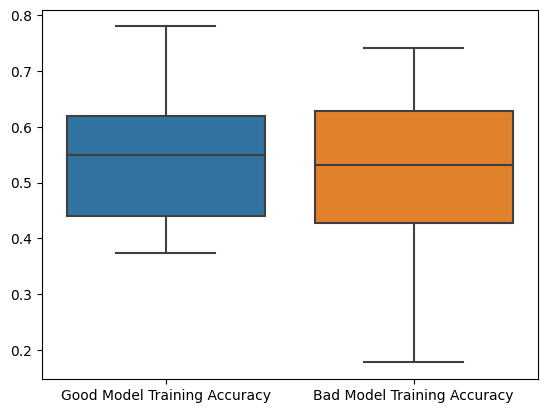

In [49]:
import seaborn as sns
sns.boxplot(data = df[['Good Model Training Accuracy', 'Bad Model Training Accuracy']])

In [50]:
evaluation_good_model_by_testing_class = {label: evaluate(best_model, DeviceDataLoader(DataLoader(testing_data_by_class[label], batch_size*2), device))['val_acc'] for label in testing_data_by_class}
evaluation_good_model_by_testing_class

{0: 0.549467921257019,
 1: 0.7599676847457886,
 2: 0.33816003799438477,
 3: 0.3820379972457886,
 4: 0.5064655542373657,
 5: 0.42046067118644714,
 6: 0.6182987689971924,
 7: 0.47979527711868286,
 8: 0.7061893939971924,
 9: 0.5652613043785095}

In [51]:
evaluation_bad_model_by_testing_class = {label: evaluate(worst_model, DeviceDataLoader(DataLoader(testing_data_by_class[label], batch_size*2), device))['val_acc'] for label in testing_data_by_class}
evaluation_bad_model_by_testing_class

{0: 0.6415342092514038,
 1: 0.723296046257019,
 2: 0.3957098722457886,
 3: 0.5420258641242981,
 4: 0.3447939157485962,
 5: 0.19302263855934143,
 6: 0.4910088777542114,
 7: 0.4904364347457886,
 8: 0.6324083805084229,
 9: 0.5320245027542114}

In [52]:
df1 = pd.DataFrame({'Classes': evaluation_good_model_by_testing_class.keys(), 'Good Model Testing Accuracy': evaluation_good_model_by_testing_class.values()})
df2 = pd.DataFrame({'Classes': evaluation_bad_model_by_testing_class.keys(), 'Bad Model Testing Accuracy': evaluation_bad_model_by_testing_class.values()})

In [53]:
df = pd.merge(df1, df2, on = 'Classes')
df

,Classes,Good Model Testing Accuracy,Bad Model Testing Accuracy
0,0,0.549468,0.641534
1,1,0.759968,0.723296
2,2,0.338160,0.395710
3,3,0.382038,0.542026
4,4,0.506466,0.344794
5,5,0.420461,0.193023
6,6,0.618299,0.491009
7,7,0.479795,0.490436
8,8,0.706189,0.632408
9,9,0.565261,0.532025


<Axes: >

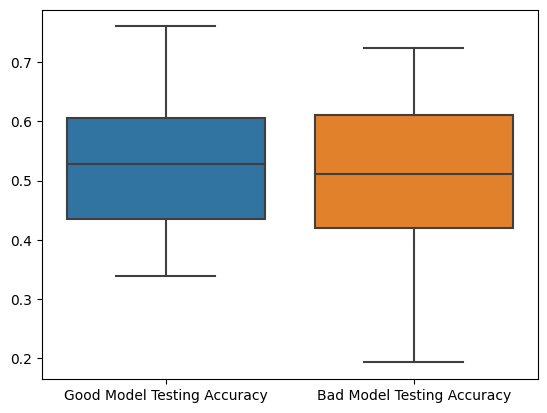

In [54]:
sns.boxplot(df[['Good Model Testing Accuracy', 'Bad Model Testing Accuracy']])